# Tp3 Part 2: Minimum-time Optimal Control (due Nov 27)

In [110]:
import time
import numpy as np
from numpy.linalg import inv,norm,pinv,svd,eig
from scipy.linalg import solve_discrete_are
import matplotlib.pylab as plt
from copy import deepcopy
from tp3 import cartpole_loader
import pinocchio as pin
from utils.meshcat_viewer_wrapper import MeshcatVisualizer
from utils.load_ur5_with_obstacles import load_ur5
import pinocchio.casadi as cpin
import casadi as cs

If importing load_ur5 fails, you may need to install the example-robot-data package in the conda environment of Tp2 and Tp3. This can be done by
```
conda install example-robot-data=4.3.0 -c conda-forge
```

In [111]:
# Load UR5 robot model
robot = load_ur5()
viz = MeshcatVisualizer(robot)
viz.display(robot.q0)

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7001/static/


In [112]:
viz.viewer.jupyter_cell()

In [113]:
# Sample initial configuration and goal configuration
pin.seed(30)
q_initial = pin.randomConfiguration(robot.model)
viz.display(q_initial)

In [114]:
q_sample = pin.randomConfiguration(robot.model)
q_goal = q_initial + 0.5 * (q_sample - q_initial)
viz.display(q_goal)

### Ex: 3.2.1: Implement an acceleration-bounded minimum time optimal control problem

In [115]:
# Time-optimal point-to-point motion planning with joint acceleration inputs 

# Joint limits
q_min = robot.model.lowerPositionLimit
q_max = robot.model.upperPositionLimit
qdot_limit = robot.model.velocityLimit
q_acc_limit = 50 # joint acceleration limits (rad/s^2)

opti = cs.Opti()

N = 50
dt = opti.variable()  # time step (actually only almost time-optimal since dt is fixed for all time steps)
opti.set_initial(dt, 0.1)

q_traj = opti.variable(robot.model.nq, N+1)  # joint positions
qdot_traj = opti.variable(robot.model.nv, N+1)  #
qddot_control = opti.variable(robot.model.nv, N)  # joint accelerations (controls)

# Initial and final conditions
opti.subject_to(q_traj[:,0] == q_initial)
opti.subject_to(qdot_traj[:,0] == 0)
opti.subject_to(qddot_control[:,0] == 0)

opti.subject_to(q_traj[:,-1] == q_goal)
opti.subject_to(qdot_traj[:,-1] == 0)
opti.subject_to(qddot_control[:,-1] == 0)

# Implement multiple-shooting Dynamics constraints (integration can be exact)
for k in range(N):
    opti.subject_to(q_traj[:, k+1] == q_traj[:, k] + qdot_traj[:, k] * dt + 0.5 * qddot_control[:, k] * dt**2)
    opti.subject_to(qdot_traj[:, k+1] == qdot_traj[:, k] + qddot_control[:, k] * dt)
# Implement joint limit constraint, joint velocity limit constraint, joint acceleration limit constraint
for k in range(N):
    opti.subject_to(q_min <= (q_traj[:,k] <= q_max))
    opti.subject_to(-qdot_limit <= (qdot_traj[:,k] <= qdot_limit))
    opti.subject_to(-q_acc_limit <= (qddot_control[:,k] <= q_acc_limit))
# Minimize total time
opti.minimize(dt)
# If you have trouble solving the problem, try to set initial guesses for the variables 
T_guess = 10.0
opti.set_initial(dt, T_guess / N)
# Linear interpolation for positions thanks LLM
for i in range(robot.model.nq):
    # Linspace from start to goal for each joint
    interpolated_traj = np.linspace(q_initial[i], q_goal[i], N+1)
    opti.set_initial(q_traj[i, :], interpolated_traj)

In [116]:
opti.solver('ipopt', {'expand':True})
sol = opti.solve()
print("Optimal time:", sol.value(dt) * N)

This is Ipopt version 3.14.17, running with linear solver MUMPS 5.7.3.

Number of nonzeros in equality constraint Jacobian...:     2736
Number of nonzeros in inequality constraint Jacobian.:      900
Number of nonzeros in Lagrangian Hessian.............:      601

Total number of variables............................:      913
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      636
Total number of inequality constraints...............:      900
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      900
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  2.0000000e-01 9.03e-02 1.00e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

In [117]:
q_traj_opt = sol.value(q_traj)
v_traj_opt = sol.value(qdot_traj)
a_traj_opt = sol.value(qddot_control)
dt_opt = sol.value(dt)

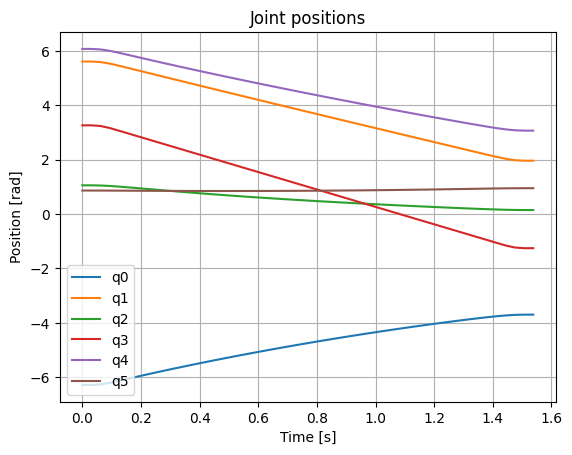

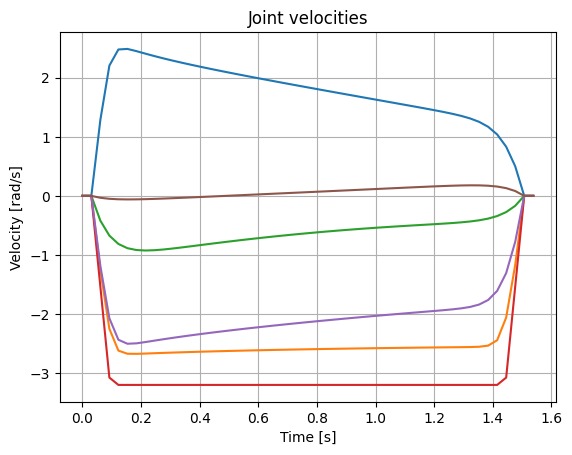

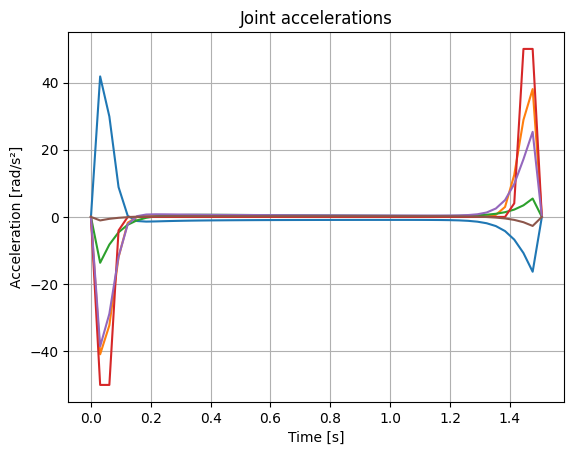

In [118]:
plt.figure()
plt.plot(np.arange(N+1)*dt_opt, q_traj_opt.T)
plt.title("Joint positions")
plt.xlabel("Time [s]")
plt.ylabel("Position [rad]")
plt.legend([f"q{i}" for i in range(robot.model.nq)])
plt.grid()
plt.figure()
plt.plot(np.arange(N+1)*dt_opt, v_traj_opt.T)
plt.title("Joint velocities")
plt.xlabel("Time [s]")
plt.ylabel("Velocity [rad/s]")
plt.grid()
plt.figure()
plt.plot(np.arange(N)*dt_opt, a_traj_opt.T)
plt.title("Joint accelerations")
plt.xlabel("Time [s]")
plt.ylabel("Acceleration [rad/s²]")
plt.grid()
plt.show()

In [119]:
viz.viewer.jupyter_cell()

In [128]:
for k in range(N+1):
    viz.display(q_traj_opt[:,k])
    time.sleep(dt_opt)

In [122]:
# Get Casadi compatible model and data
cmodel = cpin.Model(robot.model) 
cdata = cmodel.createData()

q_sym = cs.SX.sym("q", robot.model.nq)
qdot_sym = cs.SX.sym("qdot", robot.model.nv)
qddot_sym = cs.SX.sym("qddot", robot.model.nv)
tau_sym = cpin.rnea(cmodel, cdata, q_sym, qdot_sym, qddot_sym)
rnea_fun = cs.Function("rnea_casadi", [q_sym, qdot_sym, qddot_sym], [tau_sym])

torque_limit = robot.model.effortLimit*0.5

tau_traj = opti.variable(robot.model.nq, N+1)  # torque trajectory

opti.set_initial(dt, 10 / N)
# impose torque limits and store the torques in tau_traj
for k in range(N):
    opti.subject_to(tau_traj[:, k] == rnea_fun(q_traj[:, k], qdot_traj[:, k], qddot_control[:, k]))
    opti.subject_to(opti.bounded(-torque_limit, tau_traj[:, k], torque_limit))

In [124]:
sol = opti.solve()
q_traj_opt = sol.value(q_traj)
v_traj_opt = sol.value(qdot_traj)
a_traj_opt = sol.value(qddot_control)
tau_traj_opt = sol.value(tau_traj)
dt_opt = sol.value(dt)
print("Optimal time with torque limits:", dt_opt * N)

This is Ipopt version 3.14.17, running with linear solver MUMPS 5.7.3.

Number of nonzeros in equality constraint Jacobian...:    13236
Number of nonzeros in inequality constraint Jacobian.:     1500
Number of nonzeros in Lagrangian Hessian.............:     5301

Total number of variables............................:     1525
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1236
Total number of inequality constraints...............:     1500
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1500
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  2.0000000e-01 5.81e+01 1.00e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

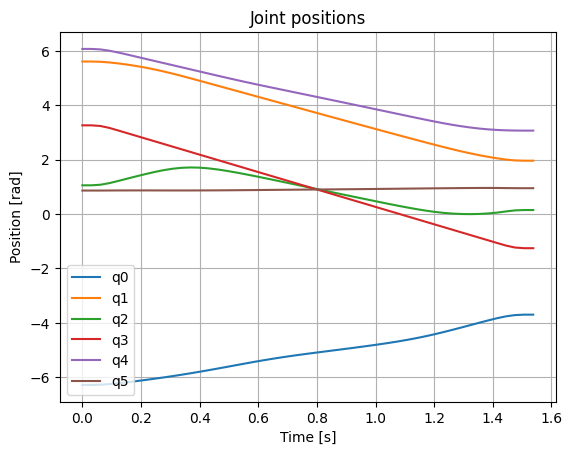

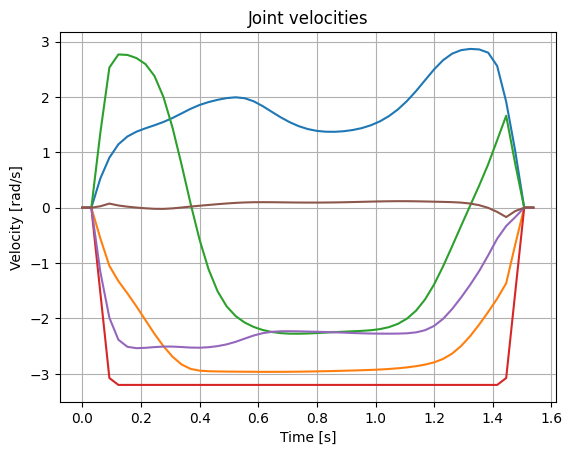

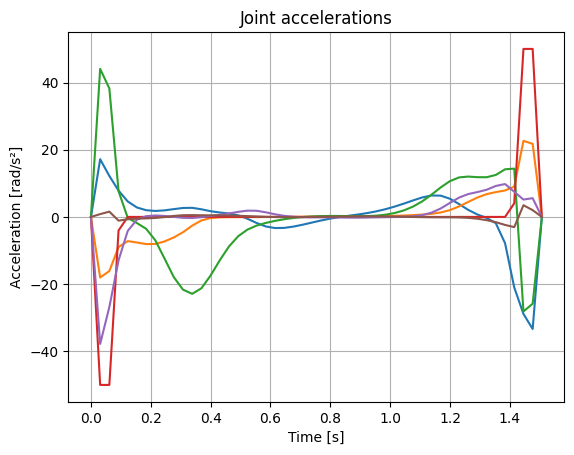

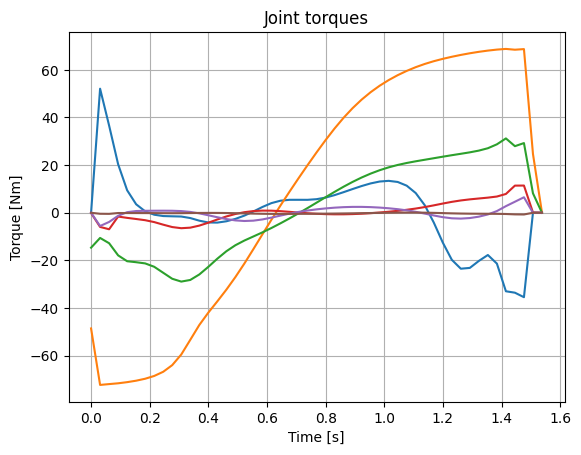

In [126]:
plt.figure()
plt.plot(np.arange(N+1)*dt_opt, q_traj_opt.T)
plt.title("Joint positions")
plt.xlabel("Time [s]")
plt.ylabel("Position [rad]")
plt.legend([f"q{i}" for i in range(robot.model.nq)])
plt.grid()
plt.show()  
plt.figure()
plt.plot(np.arange(N+1)*dt_opt, v_traj_opt.T)
plt.title("Joint velocities")
plt.xlabel("Time [s]")
plt.ylabel("Velocity [rad/s]")
plt.grid()
plt.figure()
plt.plot(np.arange(N)*dt_opt, a_traj_opt.T)
plt.title("Joint accelerations")
plt.xlabel("Time [s]")
plt.ylabel("Acceleration [rad/s²]")
plt.grid()
plt.figure()
plt.plot(np.arange(N+1)*dt_opt, tau_traj_opt.T)
plt.title("Joint torques")
plt.xlabel("Time [s]")
plt.ylabel("Torque [Nm]")
plt.grid()
plt.show()

Do the control signals look satisfactory? If not, explain why not and how it can be improved?

No my robot may do a backflip instead of going down directly and take a long path...